<a href="https://colab.research.google.com/github/AndrewWalker251/bulb_classifier/blob/master/bulb_object_detector_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [ ]:
#! pip install albumentations==0.4.6

In [3]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import ast
import torch
import torchvision
import cv2
from torchvision import transforms, datasets
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader, Dataset

%matplotlib inline

from google.colab.patches import cv2_imshow

In [4]:
# Labelbox data, convert to access required data (bounding box and class)
# Only set up to work for one object per image. 
object_labels = pd.read_csv('lightbulb_data/bulb_labels.csv')
df1 = pd.DataFrame(object_labels['Label'].apply(ast.literal_eval).values.tolist())
df2 = pd.DataFrame(df1['objects'].values.tolist())
df3 = pd.DataFrame(df2[0].values.tolist())
df4 = pd.DataFrame(df3['bbox'].values.tolist())
df = pd.concat([df4, df3['value'] ,object_labels['External ID']],axis=1)

In [5]:
df.head()

,top,left,height,width,value,External ID
0,1321,1626,779,674,b22,MVIMG_20200911_164611.jpg
1,1620,1071,933,899,b22,MVIMG_20200911_164636.jpg
2,1637,1204,625,695,b22,MVIMG_20200911_164706.jpg
3,1153,1248,440,572,b22,IMG_20200911_164514.jpg
4,1329,1257,608,669,b22,IMG_20200911_164718.jpg


In [6]:
# Modify Pytorch dataset class for object detection 

class BulbDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()
        
        self.image_ids = dataframe['External ID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[self.df['External ID'] ==image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        # How many classes are there
        num_objs = len(self.df['value'].unique())
        
        # Box coordinates
        boxes = records[['left', 'top','width', 'height']].values
        area = boxes[:,2] * boxes[:,3]
        # convert to corners of box
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        
        # Convert into tensors
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        
        # TODO this is only for one class.
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        
        if self.transforms:
            #image, target = self.transforms(image, target)
            sample = {
                'image':image,
                'bboxes':target['boxes'],
                'labels':labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)


        return image, target
        
    def __len__(self):
        return self.image_ids.shape[0]
        

In [7]:
# Albumentations library for transfors.
def get_transforms():
    return A.Compose([
        A.Resize(200, 300),
        ToTensorV2(p=1.0)], bbox_params = {'format':'pascal_voc', 'label_fields': ['labels']})


In [8]:
mybulbloader = BulbDataset(df, r'lightbulb_data/own_pictures', get_transforms())

In [9]:
dataloader_train = torch.utils.data.DataLoader(mybulbloader,
                                                 batch_size=2,
                                                 num_workers=0)

In [95]:
dataiter = iter(dataloader_train)
img, objects = dataiter.next()



In [96]:
objects

{'boxes': tensor([[[120.9821,  87.3677, 171.1310, 138.8889]],
 
         [[106.2500,  80.3571, 195.4365, 126.6369]]], dtype=torch.float64),
 'labels': tensor([[1],
         [1]])}

In [89]:
def plot_bulb_and_box(img, objects, idx):
  box = objects['boxes'][idx].numpy()

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  image = img[idx].permute(1,2,0).numpy()
  fig, ax = plt.subplots(1,1,figsize = (8,4))
  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))
  ax.imshow(image)
  plt.show()

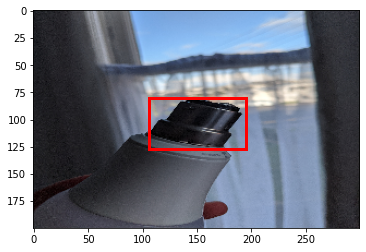

In [94]:
plot_bulb_and_box(img, objects, 1)

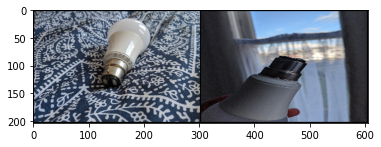

In [ ]:
# print images
imshow(torchvision.utils.make_grid(img))